# 🪄 Path 1 • Orbiting Quantum Circuits
This notebook rebuilds the prototype visualizer from scratch. It ingests any OpenQASM 2.0 file, simulates small systems exactly, and animates the circuit as an orbit of qubits on a translucent sphere. Multi-qubit gates light up edges, single-qubit gates pulse their orbit, and sliders let you scrub through time. Swap the demo path in the last cell with any QASM file to explore other circuits.

In [ ]:
%pip install -q qiskit plotly matplotlib pillow


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Sequence
import io
import math
import numpy as np
import plotly.graph_objects as go
from plotly.colors import sample_colorscale
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
print("Loaded Qiskit version:", QuantumCircuit.__module__.split('.')[0])

2.2.3


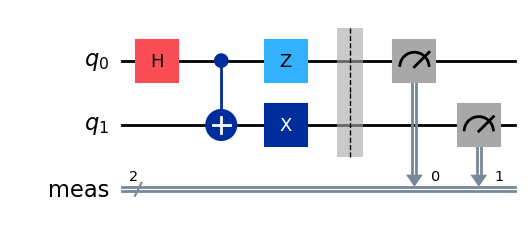

In [ ]:
PAULI_X = np.array([[0, 1], [1, 0]], dtype=complex)
PAULI_Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
PAULI_Z = np.array([[1, 0], [0, -1]], dtype=complex)

GATE_FAMILIES = {
    "single": {"color_scale": "Viridis", "marker": 10},
    "multi": {"color_scale": "Turbo", "marker": 14},
    "control": {"color_scale": "Plasma", "marker": 14}
}

def load_circuit(qasm_source: str) -> QuantumCircuit:
    """Return a QuantumCircuit from a QASM string or file path."""
    path = Path(qasm_source)
    if path.exists():
        return QuantumCircuit.from_qasm_file(path)
    return QuantumCircuit.from_qasm_str(qasm_source)

def fibonacci_sphere(samples: int, radius: float = 1.0) -> np.ndarray:
    """Distribute points roughly evenly on a sphere using the golden angle."""
    if samples == 1:
        return np.array([[0.0, 0.0, radius]])
    points = []
    golden_angle = math.pi * (3 - math.sqrt(5))
    for i in range(samples):
        y = 1 - (i / (samples - 1)) * 2  # from 1 to -1
        radius_xy = math.sqrt(max(0.0, 1 - y * y))
        theta = golden_angle * i
        x = math.cos(theta) * radius_xy
        z = math.sin(theta) * radius_xy
        points.append([radius * x, radius * y, radius * z])
    return np.array(points)

def bloch_vector(state: Statevector, qubit: int) -> np.ndarray:
    """Compute the Bloch vector for a single qubit in the state."""
    reduced = state.reduce([qubit]).data
    rx = float(np.real(np.trace(reduced @ PAULI_X)))
    ry = float(np.real(np.trace(reduced @ PAULI_Y)))
    rz = float(np.real(np.trace(reduced @ PAULI_Z)))
    return np.array([rx, ry, rz])

def gate_family(name: str, qubit_count: int) -> str:
    """Classify a gate into a visual family."""
    name = name.lower()
    if qubit_count <= 1:
        return "single"
    if name in {"cx", "cz", "swap", "cy", "ccx"}:
        return "control"
    return "multi"

             
q_0: ─■──────
      │ ┌───┐
q_1: ─■─┤ X ├
        └─┬─┘
q_2: ─────■──
             


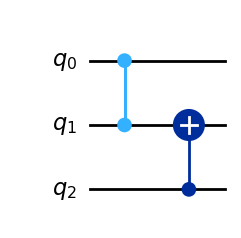

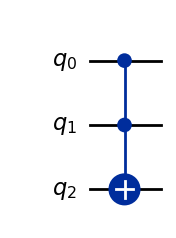

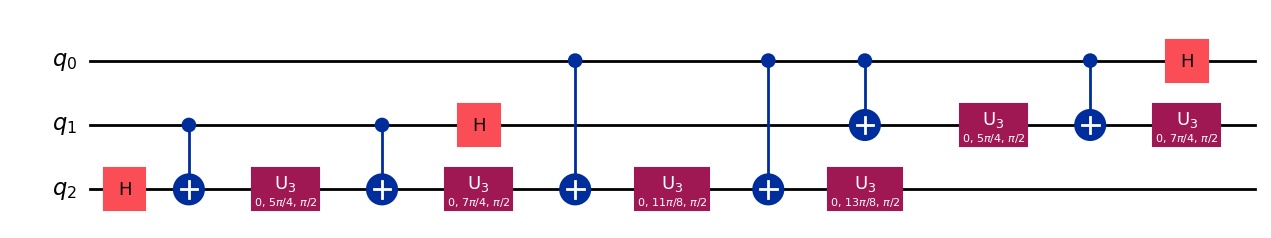

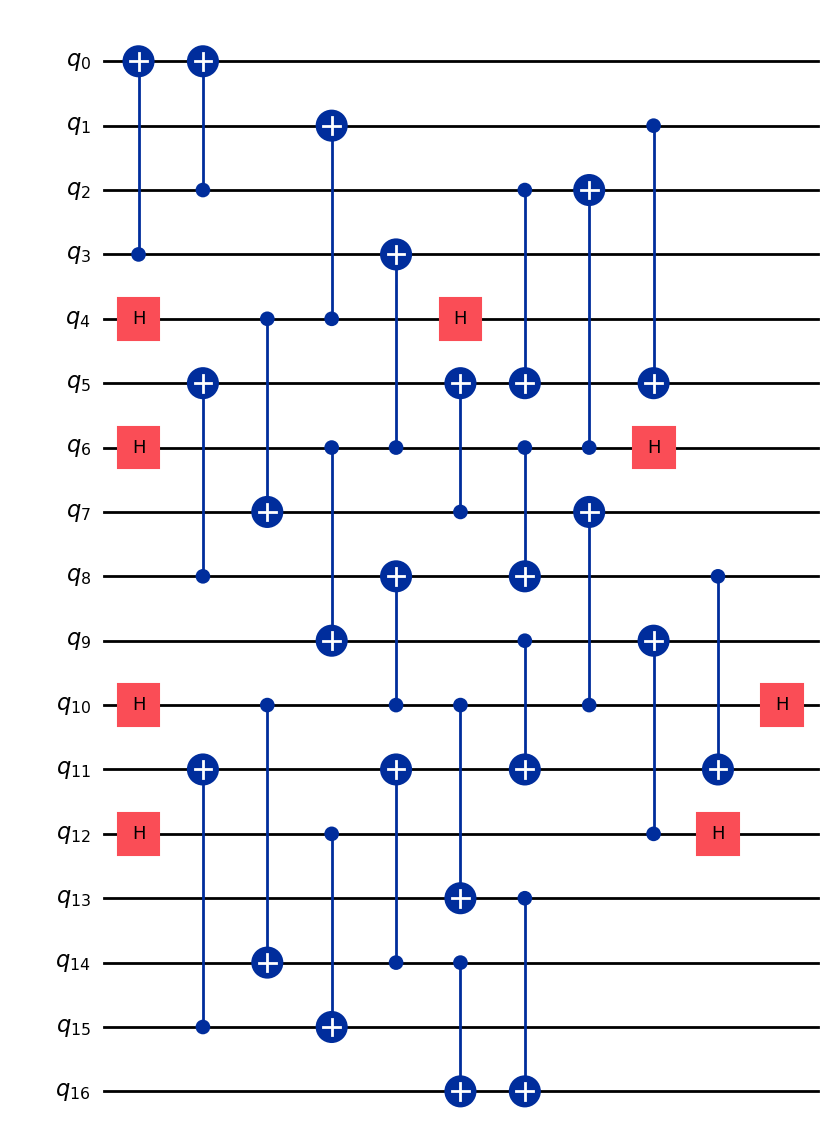

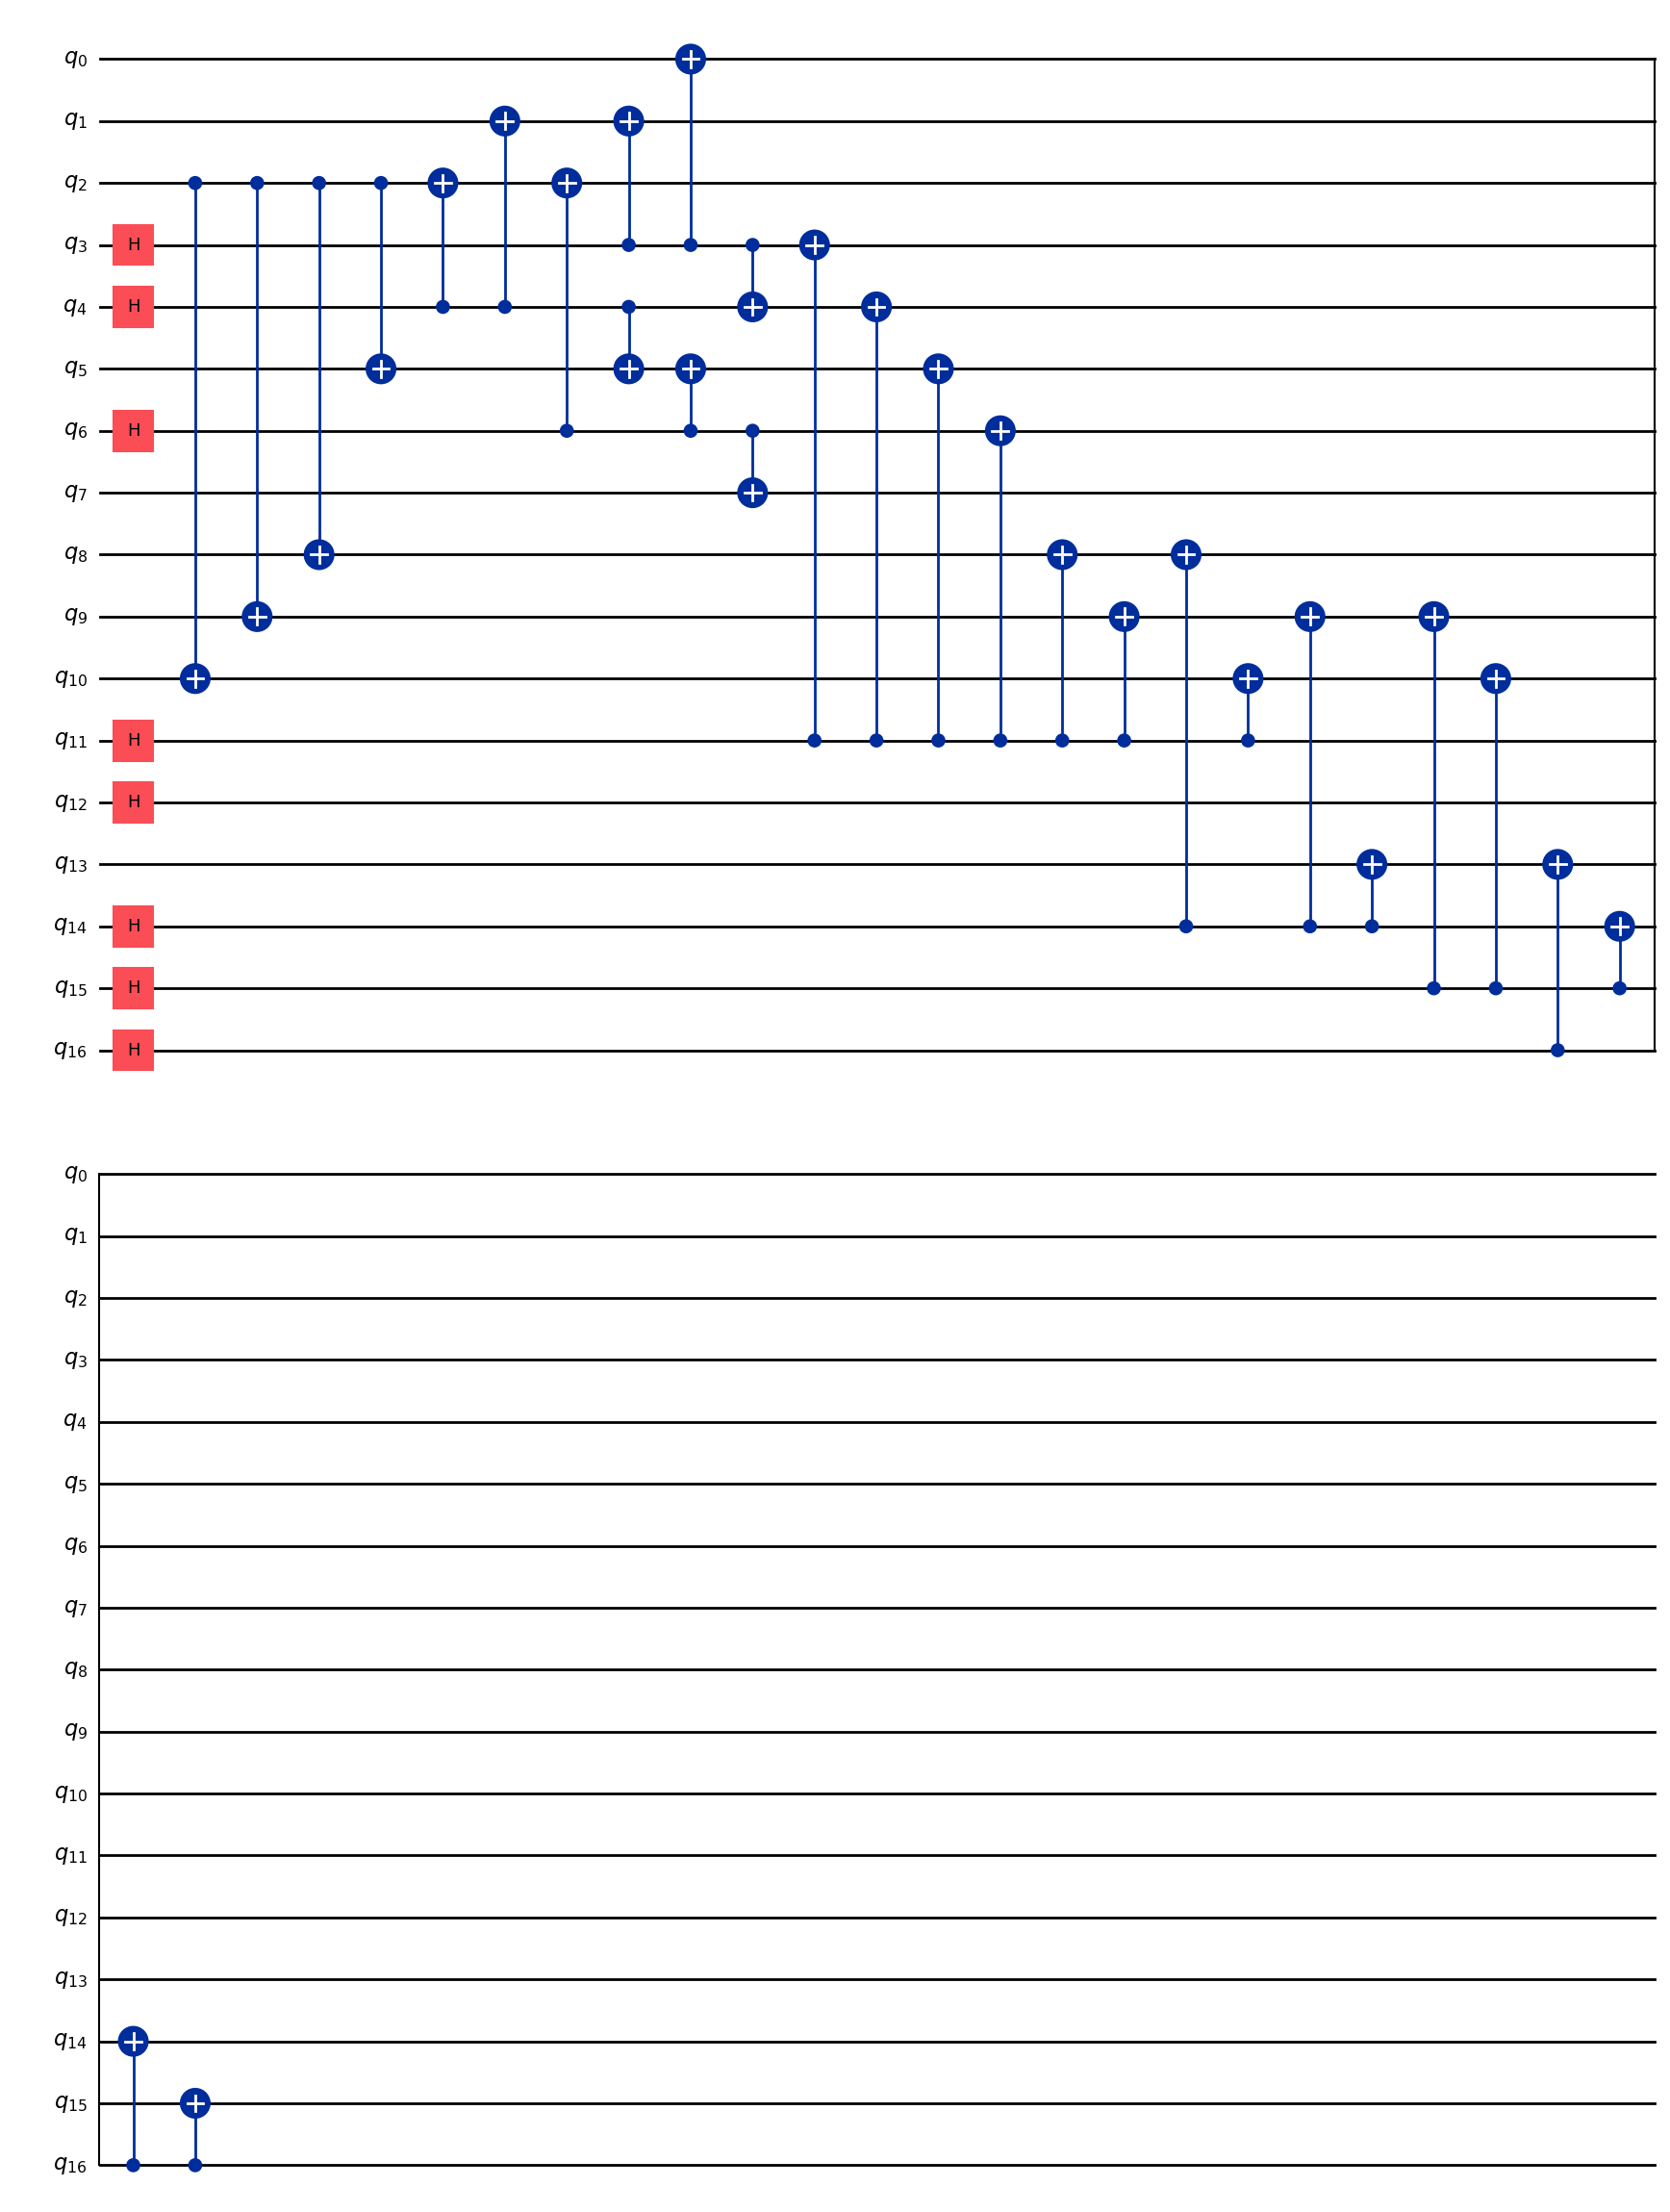

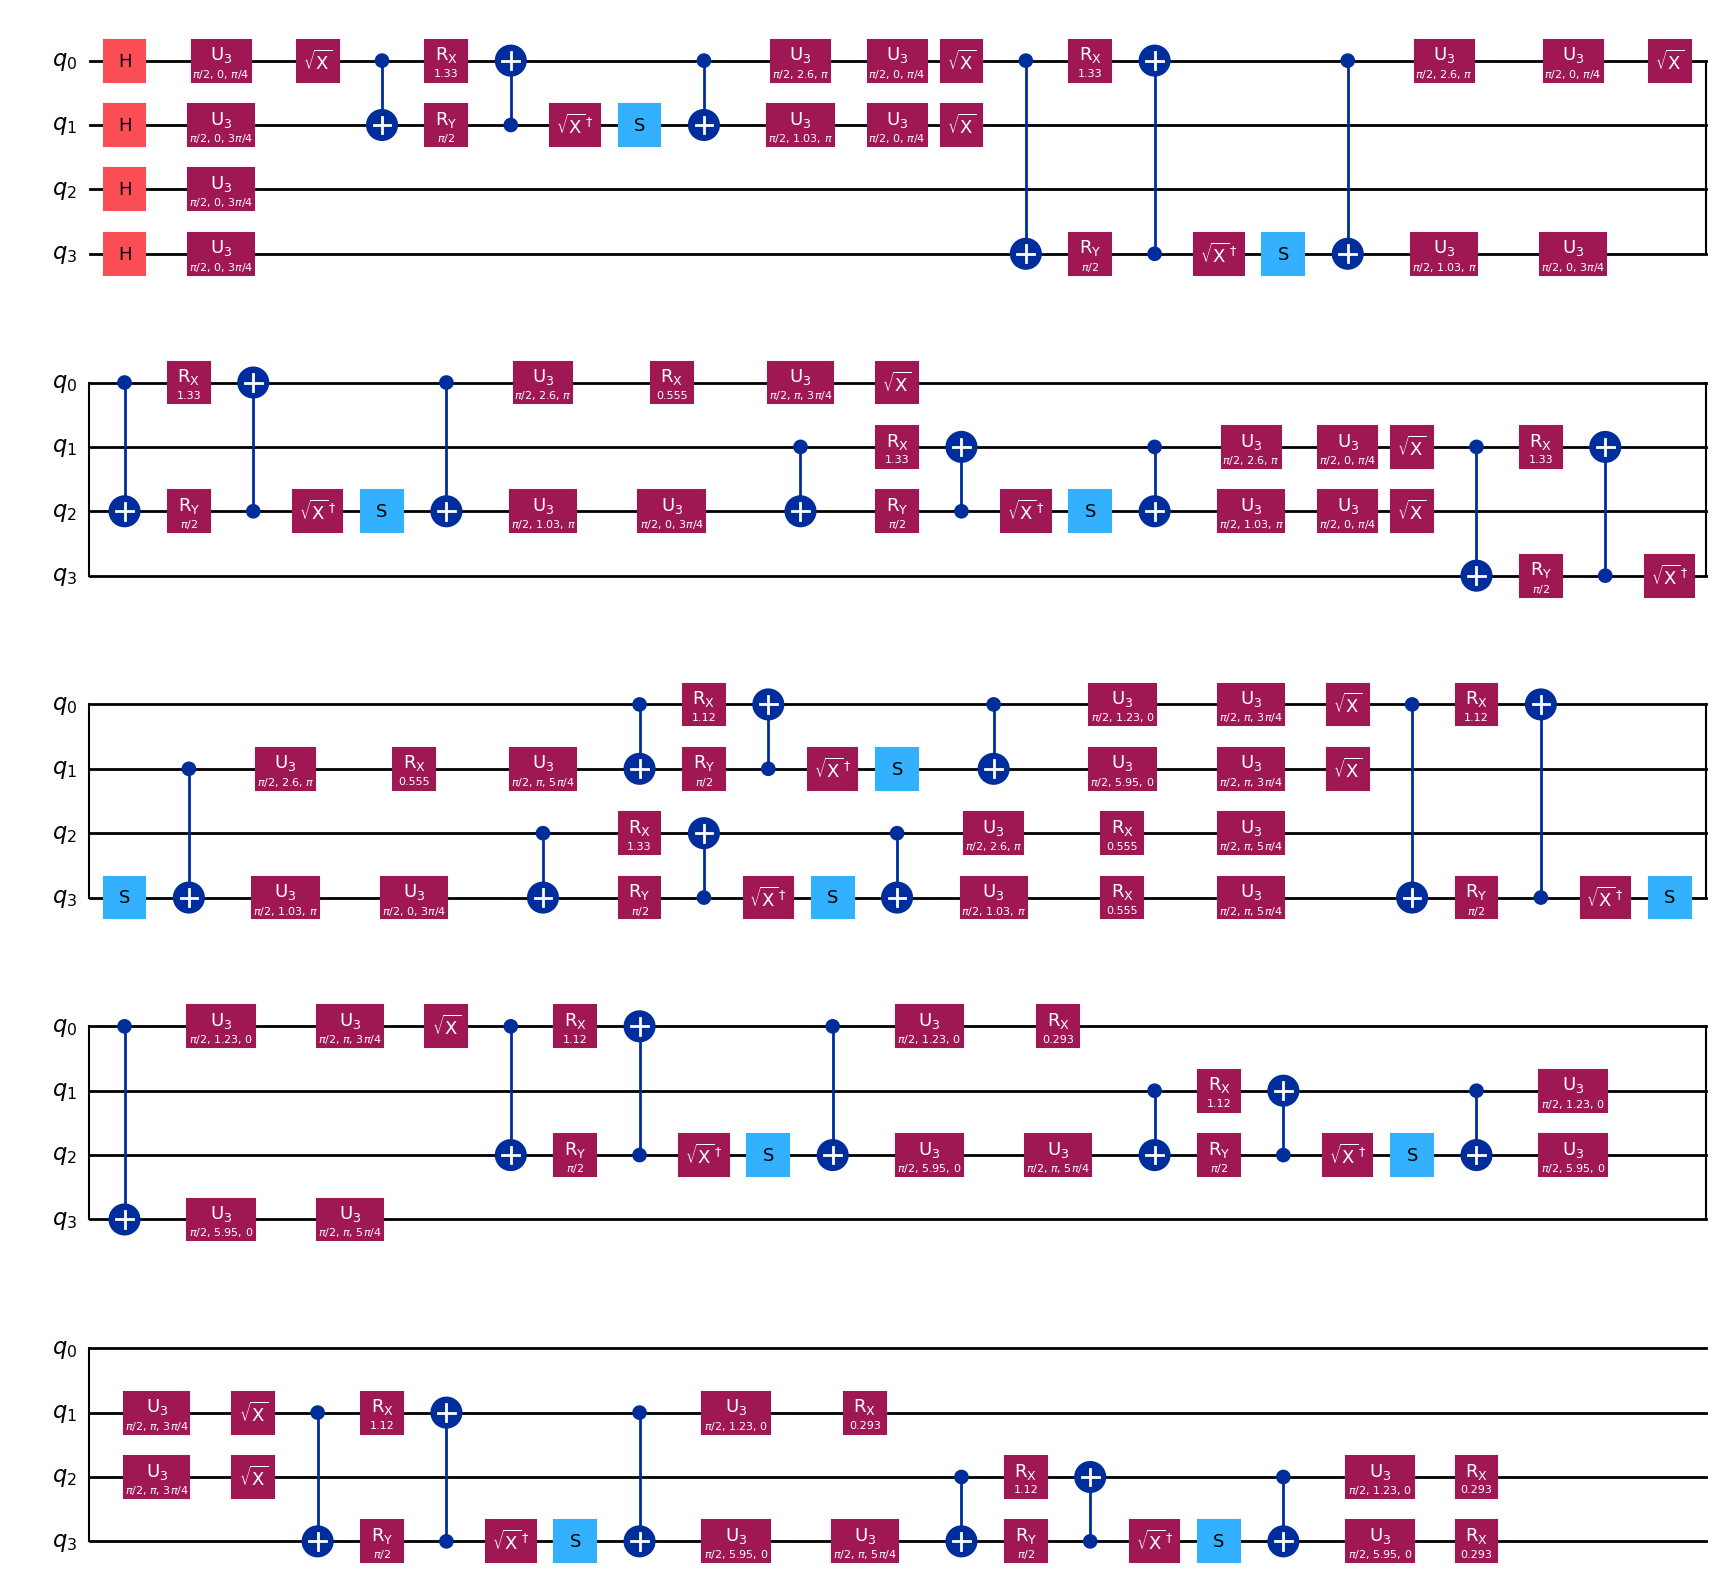

In [ ]:
@dataclass
class GateEvent:
    index: int
    name: str
    qubits: List[int]
    family: str
    bloch: Dict[int, np.ndarray]
    description: str

def collect_events(circuit: QuantumCircuit, stride: int = 1) -> List[GateEvent]:
    """Simulate the circuit gate-by-gate and capture metadata for visualization."""
    events: List[GateEvent] = []
    num_qubits = circuit.num_qubits
    track_state = num_qubits <= 8
    state = Statevector.from_label("0" * num_qubits) if track_state else None

    for idx, instruction in enumerate(circuit.data):
        name = instruction.operation.name.lower()
        if name == "barrier":
            continue
        if stride > 1 and (idx % stride) and idx != len(circuit.data) - 1:
            # Skip intermediate gates unless at the end of the circuit
            if track_state and state is not None:
                state = state.evolve(instruction.operation, qargs=instruction.qubits)
            continue
        qubits = [circuit.find_bit(q).index for q in instruction.qubits]
        if track_state and state is not None:
            state = state.evolve(instruction.operation, qargs=instruction.qubits)
            bloch = {q: bloch_vector(state, q) for q in range(num_qubits)}
        else:
            bloch = {}
        events.append(GateEvent(
            index=idx,
            name=name,
            qubits=qubits,
            family=gate_family(name, len(qubits)),
            bloch=bloch,
            description=f"Gate {idx + 1}: {name.upper()} on qubits {qubits}"
        ))
    if not events:
        events.append(GateEvent(
            index=-1,
            name="idle",
            qubits=[],
            family="single",
            bloch={q: np.array([0.0, 0.0, 1.0]) for q in range(circuit.num_qubits)},
            description="Circuit contains no operations"
        ))
    return events

def make_frame_traces(event: GateEvent, positions: np.ndarray) -> List[go.Scatter3d]:
    num_qubits = positions.shape[0]
    node_colors = []
    node_sizes = []
    for q in range(num_qubits):
        base_value = (q / max(1, num_qubits - 1)) if num_qubits > 1 else 0.5
        if event.bloch:
            bloch = event.bloch.get(q, np.array([0.0, 0.0, 1.0]))
            base_value = (bloch[2] + 1) / 2  # map Z expectation to [0,1]
        base_color = sample_colorscale(GATE_FAMILIES['single']['color_scale'], [base_value])[0]
        if q in event.qubits:
            palette = GATE_FAMILIES[event.family]['color_scale']
            emphasis = sample_colorscale(palette, [0.85])[0]
            node_colors.append(emphasis)
            node_sizes.append(GATE_FAMILIES[event.family]['marker'])
        else:
            node_colors.append(base_color)
            node_sizes.append(9)

    node_trace = go.Scatter3d(
        x=positions[:, 0],
        y=positions[:, 1],
        z=positions[:, 2],
        mode="markers+text",
        text=[f"q[{i}]" for i in range(num_qubits)],
        textposition="top center",
        hoverinfo="text",
        marker=dict(
            size=node_sizes,
            color=node_colors,
            line=dict(color="#f5f5f5", width=1)
        )
    )

    edge_x, edge_y, edge_z = [], [], []
    if len(event.qubits) >= 2:
        for i, qa in enumerate(event.qubits):
            for qb in event.qubits[i + 1:]:
                a = positions[qa]
                b = positions[qb]
                edge_x.extend([a[0], b[0], None])
                edge_y.extend([a[1], b[1], None])
                edge_z.extend([a[2], b[2], None])
    edge_trace = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode="lines",
        hoverinfo="none",
        line=dict(color=sample_colorscale(GATE_FAMILIES[event.family]['color_scale'], [0.6])[0], width=6)
    )

    if event.qubits:
        centroid = positions[event.qubits].mean(axis=0)
    else:
        centroid = np.array([0.0, 0.0, 0.0])
    label_trace = go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode="text",
        text=[event.name.upper()],
        textfont=dict(color="#ffffff", size=16, family="Montserrat"),
        hoverinfo="none"
    )

    return [node_trace, edge_trace, label_trace]

def build_animation(circuit: QuantumCircuit, events: List[GateEvent], radius: float = 1.6) -> go.Figure:
    positions = fibonacci_sphere(circuit.num_qubits, radius)
    base_traces = make_frame_traces(events[0], positions)
    frames = [go.Frame(data=make_frame_traces(ev, positions), name=f"{i:03d}") for i, ev in enumerate(events)]

    slider_steps = [
        dict(
            args=[[frame.name], {"frame": {"duration": 500, "redraw": True}, "mode": "immediate"} ],
            label=f"{ev.index + 1}: {ev.name.upper()}",
            method="animate"
        )
        for frame, ev in zip(frames, events)
    ]

    fig = go.Figure(data=base_traces, frames=frames)
    fig.update_layout(
        title=f"Quantum Circuit Orbit • {circuit.num_qubits} qubits • {len(events)} key gates",
        title_font=dict(color="#f0f4ff", size=22, family="Montserrat"),
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            bgcolor="#01040f"
        ),
        paper_bgcolor="#01040f",
        margin=dict(l=0, r=0, t=60, b=0),
        showlegend=False,
        sliders=[dict(
            steps=slider_steps,
            active=0,
            currentvalue=dict(prefix="Gate → ", font=dict(color="#f0f4ff", size=16)),
            pad=dict(t=30),
            bgcolor="#10162a"
        )],
        updatemenus=[dict(
            type="buttons",
            direction="left",
            buttons=[
                dict(
                    label="▶ Play",
                    method="animate",
                    args=[[frame.name for frame in frames], {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]
                ),
                dict(
                    label="⏸ Pause",
                    method="animate",
                    args=[[None], {"mode": "immediate", "frame": {"duration": 0, "redraw": False}}]
                )
            ],
            pad=dict(t=70, r=10),
            x=0.0,
            y=0.0,
            bgcolor="#10162a",
            bordercolor="#28304a",
            borderwidth=1
        )]
    )
    return fig

/var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/ipykernel_90135/1441429702.py:30: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, _ in full.data:
/var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/ipykernel_90135/1441429702.py:58: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for idx, (inst, qargs, _) in enumerate(circ.data, start=1):


Most entangled qubits (final single-qubit entropy): [(2, 0.6028024531539088), (3, 0.6028024531539088)]
Wrote: /var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/bloch_outputs_na448b5f/bloch_trajectories.csv
GIFs: ['/var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/bloch_outputs_na448b5f/bloch_q2.gif', '/var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/bloch_outputs_na448b5f/bloch_q3.gif']
/var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/bloch_outputs_na448b5f/bloch_q2.gif frames: 56
/var/folders/ts/_4zdq5tn21ddyh314g7h7fbc0000gn/T/bloch_outputs_na448b5f/bloch_q3.gif frames: 62



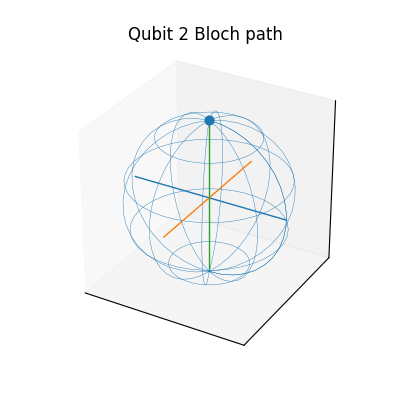


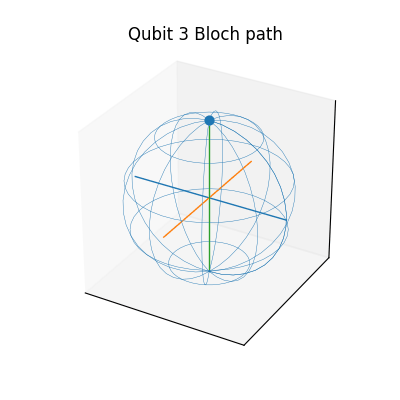

In [ ]:
def summarize_circuit(circuit: QuantumCircuit, events: Sequence[GateEvent]) -> None:
    gate_counter: Dict[str, int] = {}
    for inst, *_ in circuit.data:
        name = inst.operation.name.lower()
        if name == "barrier":
            continue
        gate_counter[name] = gate_counter.get(name, 0) + 1
    dominant = sorted(gate_counter.items(), key=lambda kv: kv[1], reverse=True)[:5]
    print("──────── Circuit Overview ────────")
    print(f"• Qubits        : {circuit.num_qubits}")
    print(f"• Classical bits: {circuit.num_clbits}")
    print(f"• Depth (est.)  : {circuit.depth()}")
    print(f"• Gates tracked : {len(events)}")
    if dominant:
        footprint = ", ".join(f"{name.upper()}×{count}" for name, count in dominant)
        print(f"• Gate footprint: {footprint}")
    else:
        print("• Gate footprint: (empty)")
    if circuit.num_qubits <= 8:
        print("• Bloch tracking: enabled (exact statevector)")
    else:
        print("• Bloch tracking: heuristic (large circuit)")
    print("──────────────────────────────────┘\n")

def visualize_qasm(qasm_source: str, stride: int = 1, radius: float = 1.6) -> None:
    """Render an animated orbit visualization for a QASM circuit."""
    circuit = load_circuit(qasm_source)
    events = collect_events(circuit, stride=stride)
    summarize_circuit(circuit, events)
    figure = build_animation(circuit, events, radius=radius)
    display(figure)

# Example: swap in any path from the circuits/ folder
# visualize_qasm("circuits/5.qasm")

In [ ]:
def single_qubit_entropy(bloch_vec: np.ndarray) -> float:
    r = np.linalg.norm(bloch_vec)
    r = min(max(r, 0.0), 1.0)
    lam = (1.0 + r) / 2.0
    if lam <= 0.0 or lam >= 1.0:
        return 0.0
    return -lam * math.log2(lam) - (1.0 - lam) * math.log2(1.0 - lam)

def circuit_bloch_trajectories(circuit: QuantumCircuit) -> Dict[int, np.ndarray]:
    if circuit.num_qubits > 8:
        raise ValueError("Bloch animation currently supports circuits with ≤ 8 qubits for exact simulation.")
    state = Statevector.from_label("0" * circuit.num_qubits)
    histories: Dict[int, List[np.ndarray]] = {q: [] for q in range(circuit.num_qubits)}
    gate_labels: List[str] = []
    for idx, instruction in enumerate(circuit.data, start=1):
        if instruction.operation.name.lower() == "barrier":
            continue
        state = state.evolve(instruction.operation, qargs=instruction.qubits)
        gate_labels.append(f"{idx}: {instruction.operation.name.upper()}")
        for q in range(circuit.num_qubits):
            histories[q].append(bloch_vector(state, q))
    if not gate_labels:
        raise ValueError("Circuit contains no gates to animate.")
    trajectories = {q: np.vstack(vectors) for q, vectors in histories.items()}
    return trajectories, gate_labels

def pick_focus_qubit(trajectories: Dict[int, np.ndarray]) -> int:
    entropy_scores = {q: single_qubit_entropy(traj[-1]) for q, traj in trajectories.items()}
    return max(entropy_scores, key=entropy_scores.get)

def render_circuit_image(circuit: QuantumCircuit, dpi: int = 150) -> np.ndarray:
    mpl_fig = circuit.draw("mpl")
    buffer = io.BytesIO()
    mpl_fig.savefig(buffer, format="png", dpi=dpi, bbox_inches="tight")
    plt.close(mpl_fig)
    buffer.seek(0)
    img = plt.imread(buffer)
    buffer.close()
    return img

def setup_bloch_axes(ax):
    u = np.linspace(0, 2 * np.pi, 40)
    v = np.linspace(0, np.pi, 20)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, color="#999999", linewidth=0.4, rstride=4, cstride=4)
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_zlim([-1.1, 1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_box_aspect([1, 1, 1])
    # Axis lines
    ax.plot([-1, 1], [0, 0], [0, 0], color="#e66", linewidth=1.2)  # X
    ax.plot([0, 0], [-1, 1], [0, 0], color="#6e6", linewidth=1.2)  # Y
    ax.plot([0, 0], [0, 0], [-1, 1], color="#66e", linewidth=1.2)  # Z
    ax.text(1.05, 0, 0, "X", color="#e66", fontsize=10)
    ax.text(0, 1.05, 0, "Y", color="#6e6", fontsize=10)
    ax.text(0, 0, 1.05, "Z", color="#66e", fontsize=10)

def animate_circuit_with_bloch(qasm_source: str, focus_qubit: int | None = None, stride: int = 1):
    circuit = load_circuit(qasm_source)
    trajectories, labels = circuit_bloch_trajectories(circuit)
    if focus_qubit is None:
        focus_qubit = pick_focus_qubit(trajectories)
    if focus_qubit not in trajectories:
        raise ValueError(f"Chosen qubit {focus_qubit} not present in circuit.")
    path = trajectories[focus_qubit]
    if stride > 1:
        path = path[::stride]
        labels = labels[::stride]
    circuit_img = render_circuit_image(circuit)
    fig = plt.figure(figsize=(11, 4.5))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.4, 1])
    ax_circuit = fig.add_subplot(gs[0, 0])
    ax_circuit.imshow(circuit_img)
    ax_circuit.axis("off")
    ax_bloch = fig.add_subplot(gs[0, 1], projection="3d")
    setup_bloch_axes(ax_bloch)
    trail, = ax_bloch.plot([], [], [], color="#46c9ff", linewidth=2.5)
    head = ax_bloch.scatter([], [], [], color="#ff6f91", s=60)
    title = ax_bloch.set_title("", fontsize=12)

    def init():
        trail.set_data([], [])
        trail.set_3d_properties([])
        head._offsets3d = ([], [], [])
        title.set_text("")
        return trail, head

    def update(frame: int):
        segment = path[: frame + 1]
        trail.set_data(segment[:, 0], segment[:, 1])
        trail.set_3d_properties(segment[:, 2])
        head._offsets3d = (segment[-1:, 0], segment[-1:, 1], segment[-1:, 2])
        title.set_text(f"Qubit {focus_qubit} Bloch Path – {labels[frame]}")
        return trail, head

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(path),
        init_func=init,
        blit=False,
        interval=650,
        repeat=False
    )
    plt.close(fig)
    return HTML(ani.to_jshtml())

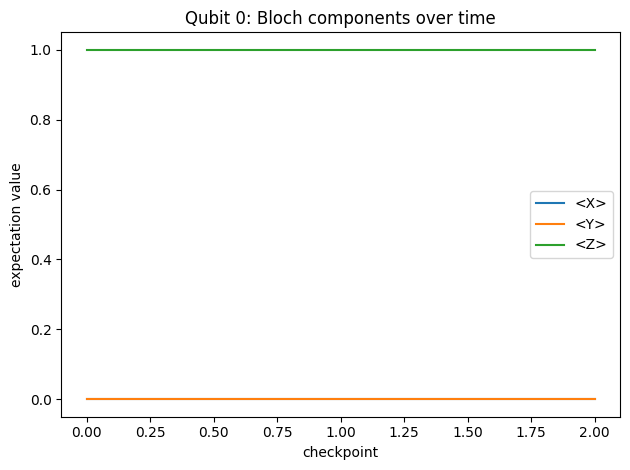

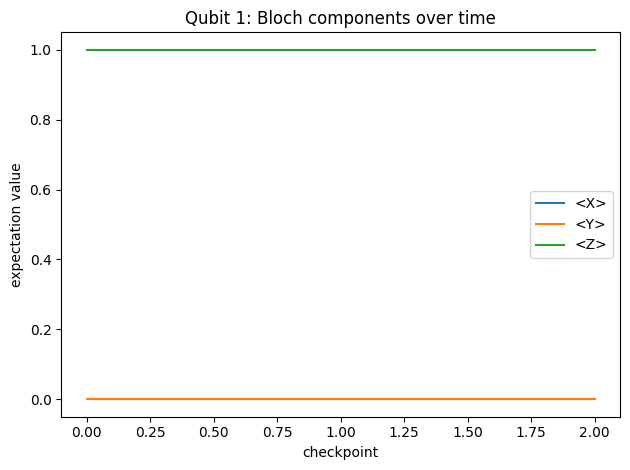

In [ ]:
# Bloch-path animation with accurate circuit diagram overlay
animate_circuit_with_bloch("circuits/3.qasm")